

#Note: Check paths before running



#Imports

In [1]:
import os
import sys
from datetime import datetime
from packaging import version
import io
import matplotlib.pyplot as plt
import imageio
import ipywidgets


import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras.layers import Dense, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical, OrderedEnqueuer

import ipywidgets
from sklearn.metrics import confusion_matrix, classification_report

# import wandb
# from wandb.keras import WandbCallback, WandbMetricsLogger
# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
np.random.seed(SEED)

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.12.0


'3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]'

##Drive mounting

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Hyperparameters

In [4]:
# DATA
BATCH_SIZE = 2

# AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (75, 75, 14, 2)
NUM_CLASSES = 1

# OPTIMIZER
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-5
DROPOUT = 0.1

# TUBELET EMBEDDING
PATCH_SIZE = 10

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 510
NUM_HEADS = 17
NUM_LAYERS = 9

#Data Generator

In [5]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, x_in, y_in, batch_size=BATCH_SIZE, shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = x_in
        self.y = y_in
        self.datalen = len(y_in)
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # get batch indexes from shuffled indexes
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = self.x[batch_indexes]
        y_batch = self.y[batch_indexes]
        return x_batch, y_batch

    def __len__(self):
        # Denotes the number of batches per epoch
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

#Cross testing the trained model

##Loading Data

In [6]:
DATA_PATH_UCF = '/content/gdrive/MyDrive/Vio_Nor_Binary_data/'

###LAD2000

In [7]:
X_train_ucf, y_train_ucf = np.load(DATA_PATH_UCF+ 'Train/X_train_dense_flow.npy',mmap_mode='r'), np.load(DATA_PATH_UCF + 'Train/y_train_dense_flow.npy', mmap_mode='r')

In [8]:
X_test_ucf, y_test_ucf = np.load(DATA_PATH_UCF+ 'Test/X_test_dense_flow.npy',mmap_mode='r'), np.load(DATA_PATH_UCF+ 'Test/y_test_dense_flow.npy',mmap_mode='r')

In [9]:
X_val_ucf, y_val_ucf = np.load(DATA_PATH_UCF + 'Val/X_val_dense_flow.npy',mmap_mode='r'), np.load(DATA_PATH_UCF + 'Val/y_val_dense_flow.npy', mmap_mode='r')

In [10]:
X_train_ucf.shape, y_train_ucf.shape

((4573, 75, 75, 14, 2), (4573,))

In [11]:
X_test_ucf.shape, y_test_ucf.shape

((1345, 75, 75, 14, 2), (1345,))

In [12]:
X_val_ucf.shape, y_val_ucf.shape

((655, 75, 75, 14, 2), (655,))

##Labels

In [13]:
from tensorflow.keras.utils import to_categorical

y_train_ucf = to_categorical(y_train_ucf, 2)
y_val_ucf = to_categorical(y_val_ucf, 2)
y_test_ucf = to_categorical(y_test_ucf, 2)

In [14]:
training_generator = DataGenerator(X_train_ucf, y_train_ucf)
validation_generator = DataGenerator(X_val_ucf, y_val_ucf)

#ViVit Model


In [15]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


In [16]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [17]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    transformer_layers,
    num_heads,
    embed_dim,
    dropout,
    input_shape=INPUT_SHAPE,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=2,
):
    input_shape = INPUT_SHAPE
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=dropout
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


##Loading the Model

In [18]:
MODEL_PATH = '/content/gdrive/MyDrive/Checkpoints/Checkpoints/hptuning-OF-lad2000-vivit/checkpoint.tf'

In [19]:
model=create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
                embed_dim=121, patch_size=(
                    3,3,3)
            ),
            positional_encoder=PositionalEncoder(embed_dim=121),
        transformer_layers=7,
        num_heads=2,
        embed_dim=121,
        dropout=0.3,
    )

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=optimizer,
        metrics=['accuracy'])

In [21]:
model = tf.keras.models.load_model(MODEL_PATH)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 14,  0           []                               
                                 2)]                                                              
                                                                                                  
 tubelet_embedding (TubeletEmbe  (None, 81, 30)      30750       ['input_1[0][0]']                
 dding)                                                                                           
                                                                                                  
 positional_encoder (Positional  (None, 81, 30)      2430        ['tubelet_embedding[0][0]']      
 Encoder)                                                                                     

In [20]:
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/ucf_of_pretrained_on_lad/checkpoint.tf/'
model_checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

In [21]:
from keras.callbacks import ReduceLROnPlateau
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/ucf_of_pretrained_on_lad/checkpoint.tf/'
checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

earlystopping = tf.keras.callbacks.EarlyStopping(
                     monitor="val_loss",
                     min_delta=0.025,
                     patience=5,
                     verbose=0,
                     mode="min",
                     baseline=None,
                     restore_best_weights=False
                 )

values = np.linspace(0.00001,LEARNING_RATE,14)[::-1].astype(np.float32)
boundaries = np.linspace(5, 45,13)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)

callbacks = [checkpoint, lr_scheduler, reduce_lr]

In [22]:
def run_experiment():
    model = tf.keras.models.load_model(MODEL_PATH)

    # Compile the model with the optimizer, loss function
    # and the metrics.
    new_model = model
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    new_model.compile(loss=loss_fn,optimizer=opt,metrics=['accuracy'])
    #model.load_weights(checkpoint_filepath)
    # Train the model.
    with tf.device('/GPU:0'):
      history = new_model.fit(training_generator, epochs=5, validation_data=(validation_generator), callbacks=[model_checkpoint, callbacks])

    return new_model, history


model, history = run_experiment()


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/5
2286/2286 [==============================] - 1102s 391ms/step - loss: 0.5579 - accuracy: 0.7098 - val_loss: 0.3518 - val_accuracy: 0.8425 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/5
2286/2286 [==============================] - 765s 335ms/step - loss: 0.4102 - accuracy: 0.8084 - val_loss: 0.3603 - val_accuracy: 0.8440 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/5
2286/2286 [==============================] - 780s 341ms/step - loss: 0.3479 - accuracy: 0.8478 - val_loss: 0.3202 - val_accuracy: 0.8578 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/5
2286/2286 [==============================] - 764s 334ms/step - loss: 0.3111 - accuracy: 0.8666 - val_loss: 0.3702 - val_accuracy: 0.8532 - lr: 1.0000e-04

Epoch 5: LearningRateS

#Testing

In [23]:
# @title
import plotly.figure_factory as ff

def eval_model(model,x,y):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y,axis=-1)

    target_names = ['normal','violence']
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))

    z = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    z = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=3)

    x = target_names
    y = target_names

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                    #xaxis = dict(title='x'),
                    #yaxis = dict(title='x')
                    )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()


##Note: you may replicate the next cell to test on the train, validation or test dataset

##Testing on LAd2000

In [24]:
eval_model(model, X_test_ucf, y_test_ucf)

43/43 [==============================] - 16s 132ms/step
              precision    recall  f1-score   support

      normal       0.79      0.72      0.76       682
    violence       0.74      0.81      0.77       663

    accuracy                           0.76      1345
   macro avg       0.77      0.76      0.76      1345
weighted avg       0.77      0.76      0.76      1345



In [25]:
model.evaluate(X_test_ucf, y_test_ucf)

43/43 [==============================] - 7s 149ms/step - loss: 0.5305 - accuracy: 0.7643


[0.5305256843566895, 0.7643122673034668]

In [26]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm

def eval_model_f(model,x,y):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y,axis=-1)

    target_names = [
  'normal', 'violence'
    ]
    tick_marks = np.arange(len(target_names))
    print(classification_report(y_numbers, y_pred, target_names=target_names))

    conf = cm(y_numbers,y_pred)

    sns.heatmap(conf,annot=True)
    plt.xticks(tick_marks,target_names,rotation=45)
    plt.yticks(tick_marks,target_names,rotation=0)
    plt.show()

43/43 [==============================] - 6s 145ms/step
              precision    recall  f1-score   support

      normal       0.79      0.72      0.76       682
    violence       0.74      0.81      0.77       663

    accuracy                           0.76      1345
   macro avg       0.77      0.76      0.76      1345
weighted avg       0.77      0.76      0.76      1345



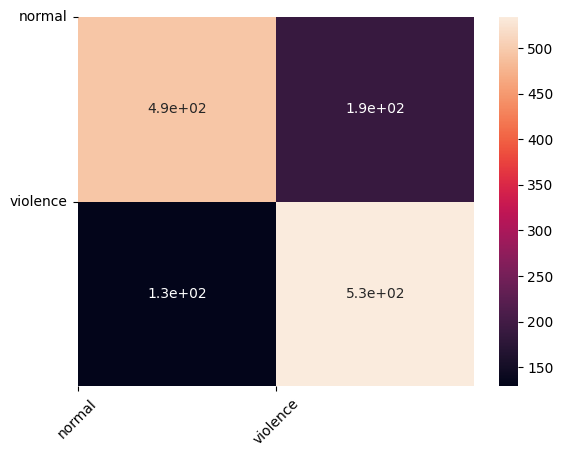

In [27]:
eval_model_f(model,X_test_ucf,y_test_ucf)